In [1]:
from datascience import *
%matplotlib inline
path_data = '../../../assets/data/'
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import numpy as np

# The Bootstrap
A data scientist is using the data in a random sample to estimate an unknown parameter. She uses the sample to calculate the value of a statistic that she will use as her estimate. 

Once she has calculated the observed value of her statistic, she could just present it as her estimate and go on her merry way. But she's a data scientist. She knows that her random sample is just one of numerous possible random samples, and thus her estimate is just one of numerous plausible estimates. 

By how much could those estimates vary? To answer this, it appears as though she needs to draw another sample from the population, and compute a new estimate based on the new sample. But she doesn't have the resources to go back to the population and draw another sample.

It looks as though the data scientist is stuck.

Fortunately, a brilliant idea called *the bootstrap* can help her out. Since it is not feasible to generate new samples from the population, the bootstrap generates new random samples by a method called *resampling*: the new samples are drawn at random *from the original sample*.

In this section, we will see how and why the bootstrap works. In the rest of the chapter, we will use the bootstrap for inference.



## Employee Compensation in the City of San Francisco
[SF OpenData](https://data.sfgov.org) is a website where the City and County of San Francisco make some of their data publicly available. One of the data sets contains compensation data for employees of the City. These include medical professionals at City-run hospitals, police officers, fire fighters, transportation workers, elected officials, and all other employees of the City. 

Compensation data for the calendar year 2019 are in the table `sf2019`.

In [2]:
sf2019 = Table.read_table(path_data + 'san_francisco_2019.csv')

In [3]:
sf2019.show(3)

There is one row for each of over 44,500 employees. There are numerous columns containing information about City departmental affiliation and details of the different parts of the employee's compensation package. Here is the row corresponding to London Breed, the Mayor of San Francisco in 2019.

In [4]:
sf2019.where('Job', 'Mayor')

Organization Group               | Department | Job Family                    | Job   | Salary | Overtime | Benefits | Total Compensation
General Administration & Finance | Mayor      | Administrative & Mgmt (Unrep) | Mayor | 342974 | 0        | 98012    | 440987

We are going to study the final column, `Total Compensation`. That's the employee's salary plus the City's contribution towards their retirement and benefit plans.

Financial packages in a calendar year can sometimes be hard to understand as they depend on the date of hire, whether the employee is changing jobs within the City, and so on. For example, the lowest values in the `Total Compensation` column look a little strange.

In [5]:
sf2019.sort('Total Compensation')

Organization Group                      | Department         | Job Family                    | Job                            | Salary | Overtime | Benefits | Total Compensation
Public Protection                       | Adult Probation    | Probation & Parole            | Deputy Probation Officer       | 0      | 0        | 0        | 0
Public Protection                       | Fire Department    | Clerical, Secretarial & Steno | Senior Clerk Typist            | 0      | 0        | 0        | 0
Public Protection                       | Juvenile Court     | Correction & Detention        | Counselor, Juvenile Hall PERS  | 0      | 0        | 0        | 0
Public Protection                       | Police             | Clerical, Secretarial & Steno | Clerk Typist                   | 0      | 0        | 0        | 0
Public Protection                       | Sheriff            | Correction & Detention        | Deputy Sheriff                 | 0      | 0        | 0        | 0
Public Works, Transportation & Commerce | Airport Commission | Sub-Professional Engineering  | StdntDsgn Train2/Arch/Eng/Plng | 0      | 0        | 0        | 0
Public Works, Transportation & Commerce | Airport Commission | Clerical, Secretarial & Steno | Executive Secretary 1          | 0      | 0        | 0        | 0
Public Works, Transportation & Commerce | Airport Commission | Payroll, Billing & Accounting | Senior Account Clerk           | 0      | 0        | 0        | 0
Public Works, Transportation & Commerce | Airport Commission | Housekeeping & Laundry        | Custodian                      | 0      | 0        | 0        | 0
Public Works, Transportation & Commerce | Airport Commission | Housekeeping & Laundry        | Custodian                      | 0      | 0        | 0        | 0
... (44515 rows omitted)

For clarity of interpretation, we will focus our attention on those who had roughly the equivalent of a half-time job or more for the whole year. At a minimum wage of about 15 dollars per hour, and 20 hours per week for 52 weeks, that's a salary of over 15,000 dollars.

In [6]:
sf2019 = sf2019.where('Salary', are.above(15000))

In [7]:
sf2019.num_rows

37103

## Population and Parameter
Let this table of just over 37,000 rows be our population. Here is a histogram of the total compensations for the employees in this table.

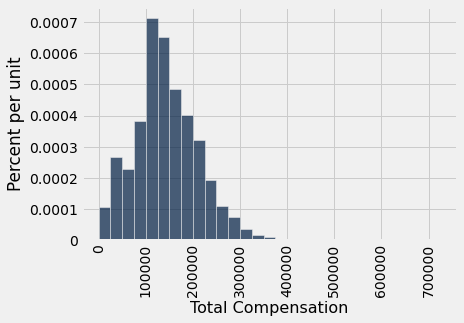

In [8]:
sf_bins = np.arange(0, 726000, 25000)
sf2019.select('Total Compensation').hist(bins=sf_bins)

While most of the values are below 300,000 dollars, a few are quite a bit higher. For example, the total compensation of the Chief Investment Officer was over 700,000 dollars. That is why the horizontal axis stretches quite far to the right of the visible bars.

In [9]:
sf2019.sort('Total Compensation', descending=True).show(2)

Suppose the parameter in which we are interested is the median of the total compensations.

Since we have the luxury of having all of the data from the population, we can simply calculate the parameter:

In [10]:
pop_median = percentile(50, sf2019.column('Total Compensation'))
pop_median

135747.0

The median total compensation of all the employees was 135,747 dollars. 

From a practical perspective, there is no reason for us to draw a sample to estimate this parameter since we simply know its value. But in this section we are going to pretend we don't know the value, and see how well we can estimate it based on a random sample. 

In later sections, we will come down to earth and work in situations where the parameter is unknown. For now, we are all-knowing.

## A Random Sample and an Estimate
Let us draw a sample of 500 employees at random without replacement, and let the median total compensation of the sampled employees serve as our estimate of the parameter.

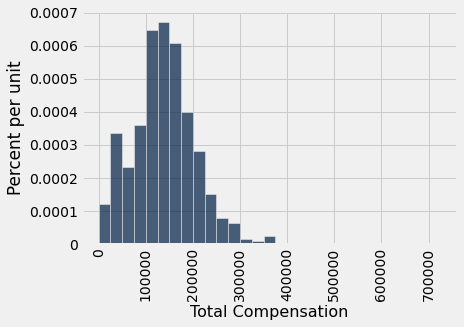

In [13]:
our_sample = sf2019.sample(500, with_replacement=False)
our_sample.select('Total Compensation').hist(bins=sf_bins)

In [14]:
est_median = percentile(50, our_sample.column('Total Compensation'))
est_median

136835.0

The sample size is large. By the law of averages, the distribution of the sample resembles that of the population. Consequently the sample median is quite comparable to the population median, though of course it is not exactly the same.

So now we have one estimate of the parameter. But had the sample come out differently, the estimate would have had a different value. We would like to be able to quantify the amount by which the estimate could vary across samples. That measure of variability will help us measure how accurately we can estimate the parameter.

To see how different the estimate would be if the sample had come out differently, we could just draw another sample from the population. But that would be cheating. We are trying to mimic real life, in which we won't have all the population data at hand.

Somehow, we have to get another random sample *without sampling again from the population*.

## The Bootstrap: Resampling from the Sample

What we do have is a large random sample from the population. As we know, a large random sample is likely to resemble the population from which it is drawn. This observation allows data scientists to *lift themselves up by their own bootstraps*: the sampling procedure can be replicated by *sampling from the sample*. 

Here are the steps of *the bootstrap method* for generating another random sample that resembles the population:

- **Treat the original sample as if it were the population.**
- **Draw from the sample, at random with replacement, the same number of times as the original sample size**. 

It is important to resample the same number of times as the original sample size. The reason is that the variability of an estimate depends on the size of the sample. Since our original sample consisted of 500 employees, our sample median was based on 500 values. To see how different the sample could have been, we have to compare it to the median of other samples of size 500.

If we drew 500 times at random *without* replacement from our sample of size 500, we would just get the same sample back. By drawing *with* replacement, we create the possibility for the new samples to be different from the original, because some employees might be drawn more than once and others not at all.

## Why the Bootstrap Works

Why is this a good idea? By the law of averages, the distribution of the original sample is likely to resemble the population, and the distributions of all the "resamples" are likely to resemble the original sample. So the distributions of all the resamples are likely to resemble the population as well. 

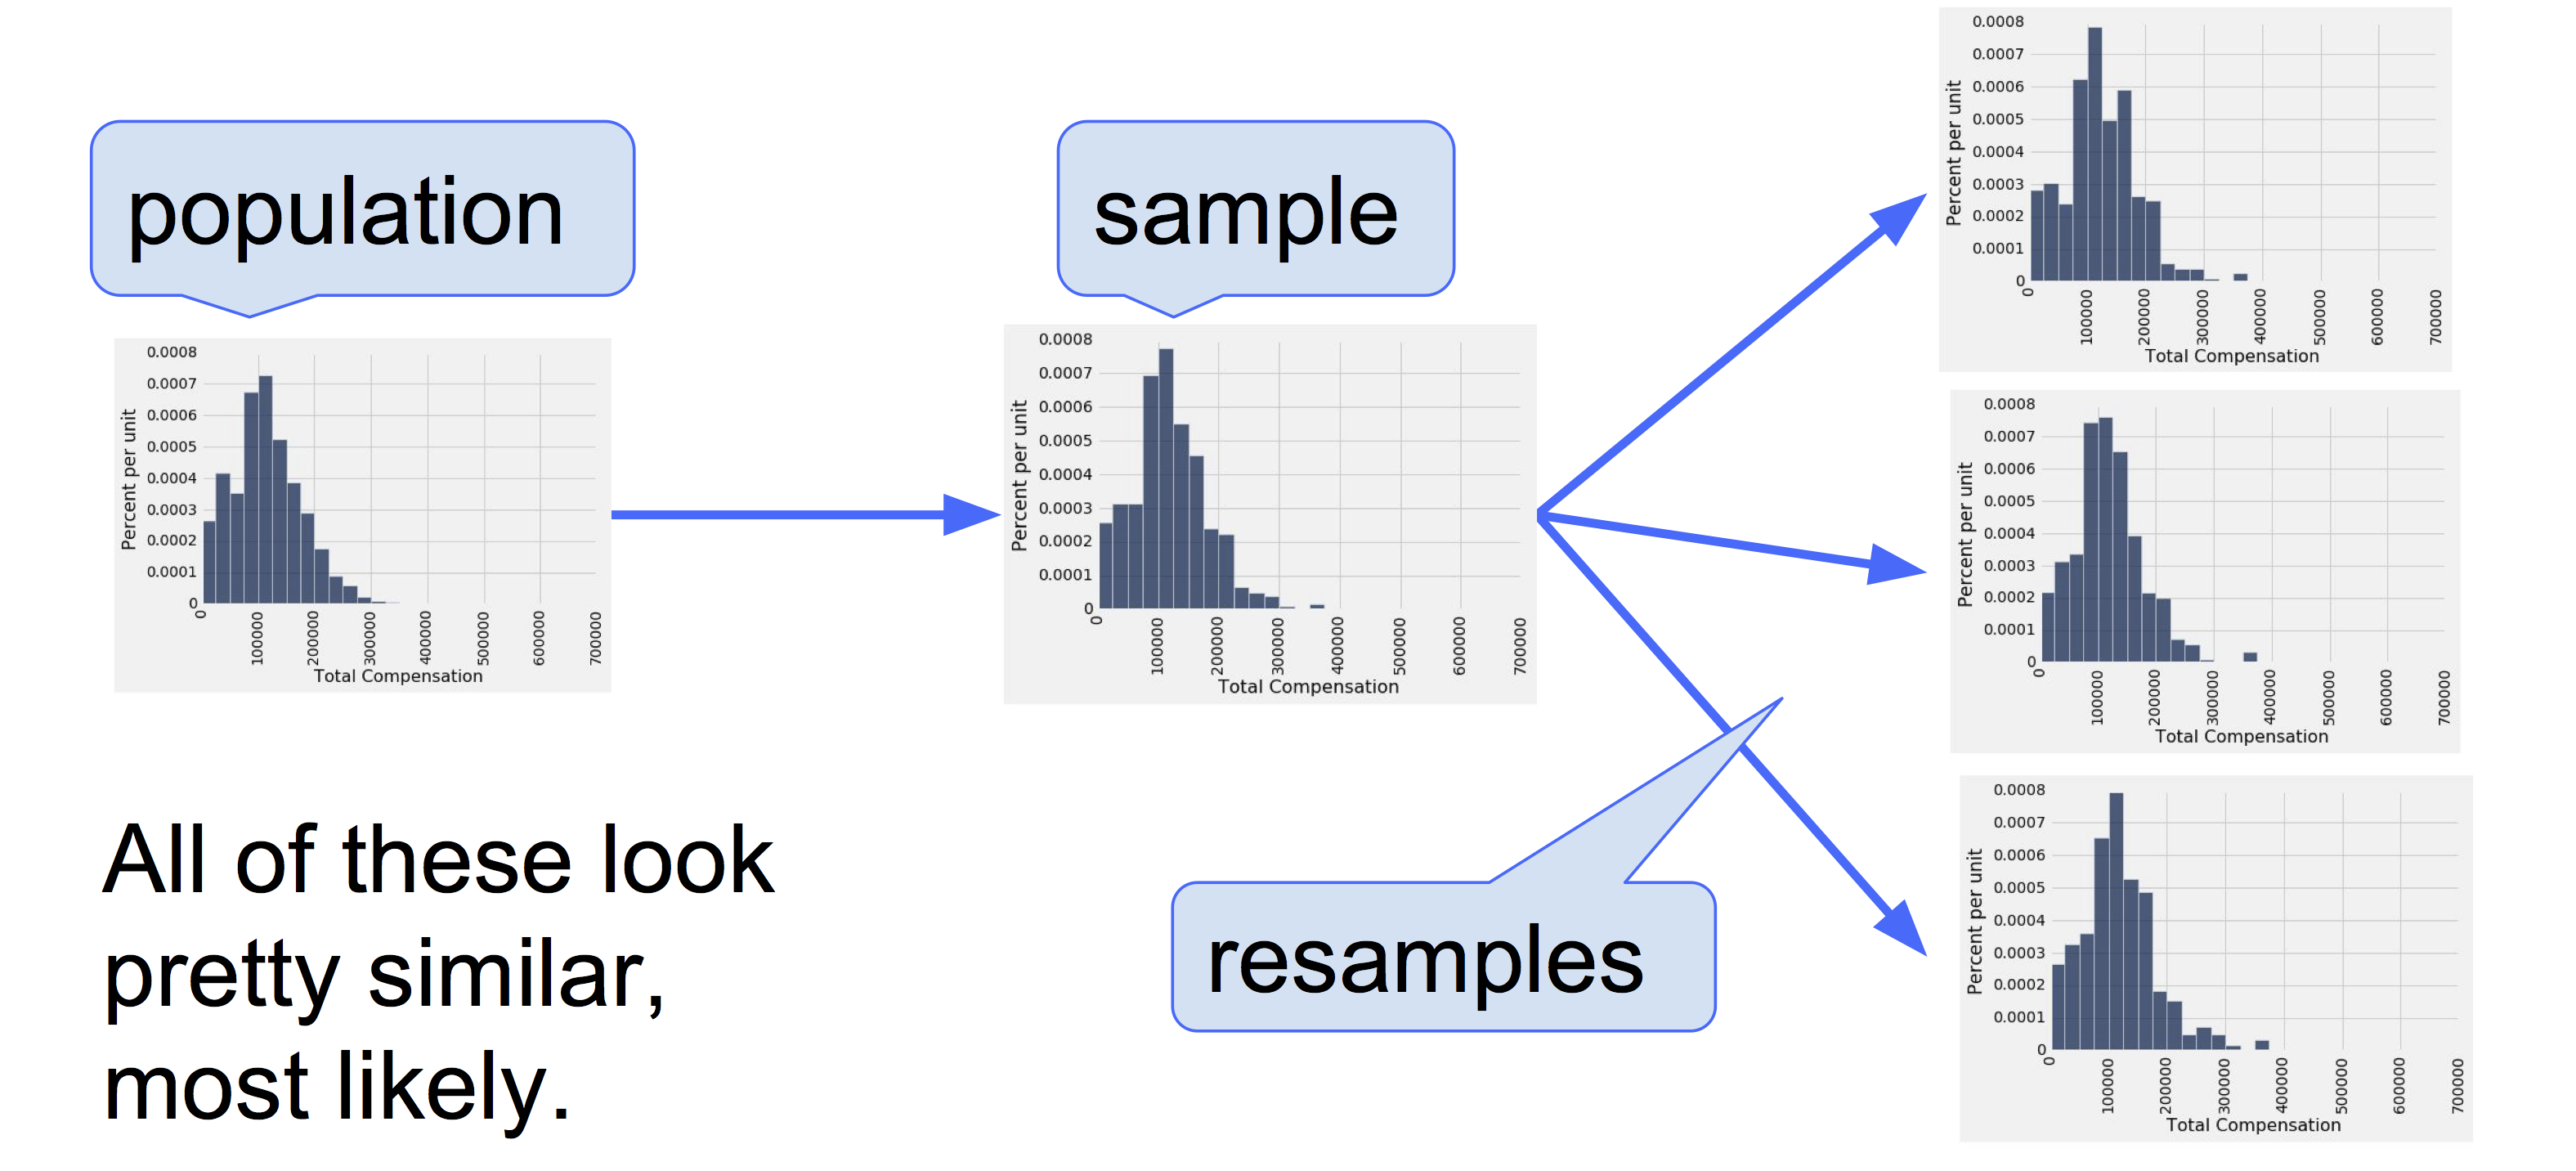

In [4]:
from IPython.display import Image
Image("../../../images/bootstrap_pic.png")

## A Resampled Median
Recall that the `sample` method draws rows from a table with replacement by default, and when it is used without specifying a sample size, by default the sample size equals the number of rows of the table. That's perfect for the bootstrap! Here is one new sample drawn from the original sample, and the corresponding sample median.

In [15]:
resample_1 = our_sample.sample()

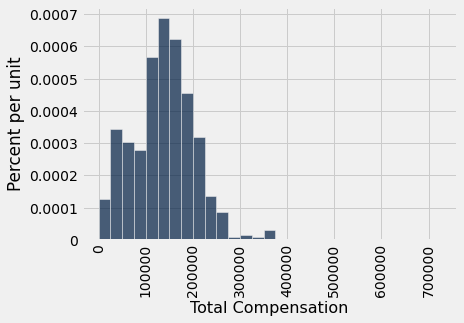

In [16]:
resample_1.select('Total Compensation').hist(bins=sf_bins)

In [17]:
resampled_median_1 = percentile(50, resample_1.column('Total Compensation'))
resampled_median_1

141793.0

This value is an estimate of the population median.

By resampling again and again, we can get many such estimates, and hence an empirical distribution of the estimates.

In [18]:
resample_2 = our_sample.sample()
resampled_median_2 = percentile(50, resample_2.column('Total Compensation'))
resampled_median_2

135880.0

Let us collect this code and define a function `one_bootstrap_median` that returns one bootstrapped median of total compensation, based on bootstrapping the original random sample that we called `our_sample`.

In [19]:
def one_bootstrap_median():
    resampled_table = our_sample.sample()
    bootstrapped_median = percentile(50, resampled_table.column('Total Compensation'))
    return bootstrapped_median

Run the cell below a few times to see how the bootstrapped medians vary. Remember that each of them is an estimate of the population median.

In [20]:
one_bootstrap_median()

132175.0

## Bootstrap Empirical Distribution of the Sample Median

We can now repeat the bootstrap process multiple times by running a `for` loop as usual. In each iteration, we will call the function `one_bootstrap_median` to generate one value of the bootstrapped median based on our original sample `our_sample`. Then we will append the bootstrapped median to the collection array `bstrap_medians`.

Since we are asking for 5000 repetitions, the code might take a while to run. It has a lot of resampling to do!

In [21]:
num_repetitions = 5000
bstrap_medians = make_array()
for i in np.arange(num_repetitions):
    bstrap_medians = np.append (bstrap_medians, one_bootstrap_median())

Here is an empirical histogram of the 5000 bootstrapped medians. The green dot is the population parameter: it is the median of the entire population, which is what we are trying to estimate. In this example we happen to know its value, but we did not use it in the bootstrap process.

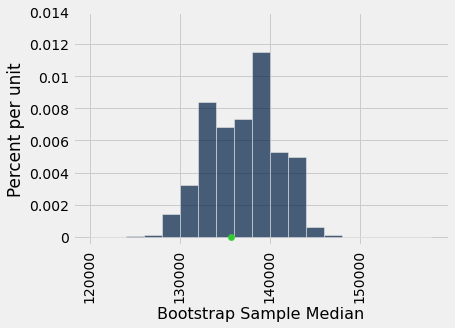

In [22]:
resampled_medians = Table().with_column('Bootstrap Sample Median', bstrap_medians)
median_bins=np.arange(120000, 160000, 2000)
resampled_medians.hist(bins = median_bins)

# Plotting parameters; you can ignore this code
parameter_green = '#32CD32'
plots.ylim(-0.000005, 0.00014)
plots.scatter(pop_median, 0, color=parameter_green, s=40, zorder=2);

It is important to remember that the green dot is fixed: it is 135,747 dollars, the population median. The empirical histogram is the result of random draws, and will be situated randomly relative to the green dot. 

Remember also that the point of all these computations is to estimate the population median, which is the green dot. Our estimates are all the randomly generated sampled medians whose histogram you see above. We want the set of these estimates to contain the parameter. If it doesn't, then the estimates are off.

## Do the Estimates Capture the Parameter?

How often does the empirical histogram of the resampled medians sit firmly over the green dot, and not just brush the dot with its tails or not cover it at all? To answer this, we must define "sit firmly". Let's take that to mean "the middle 95% of the resampled medians contains the green dot". 

Here are the two ends of the "middle 95%" interval of resampled medians:

In [23]:
left = percentile(2.5, bstrap_medians)
left

129524.0

In [24]:
right = percentile(97.5, bstrap_medians)
right

143446.0

The population median of 135,747 dollars is between these two numbers. The interval and the population median are shown on the histogram below.

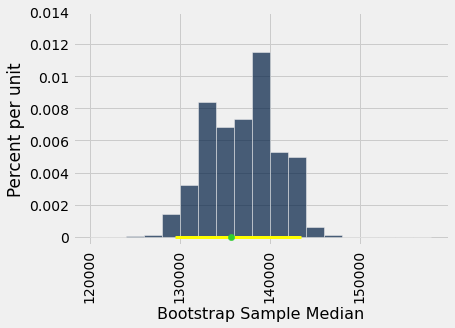

In [25]:
resampled_medians.hist(bins = median_bins)

# Plotting parameters; you can ignore this code
plots.ylim(-0.000005, 0.00014)
plots.plot([left, right], [0, 0], color='yellow', lw=3, zorder=1)
plots.scatter(pop_median, 0, color=parameter_green, s=40, zorder=2);

The "middle 95%" interval of estimates captured the parameter in our example. But was that a fluke? 

To see how frequently the interval contains the parameter, we have to run the entire process over and over again. Specifically, we will replicate the following process 100 times:

- Draw an original random sample of size 500 from the population.
- Carry out 5000 replications of the bootstrap process and generate the "middle 95%" interval of resampled medians.

We will end up with 100 intervals, and count how many of them contain the population median.

**Spoiler alert:** The statistical theory of the bootstrap says that the number should be around 95. It may be in the low 90s or high 90s, but we don't expect it to be much farther off 95 than that.

We will start by writing a function `bootstrap_median` that takes two arguments: the name of the table containing the original random sample, and the number of bootstrap samples to draw. It returns an array of bootstrapped medians, one from each bootstrap sample.

In [117]:
def bootstrap_median(original_sample, num_repetitions):
    medians = make_array()
    for i in np.arange(num_repetitions):
        new_bstrap_sample = original_sample.sample()
        new_bstrap_median = percentile(50, new_bstrap_sample.column('Total Compensation'))
        medians = np.append(medians, new_bstrap_median)
    return medians

Now we will write a `for` loop that calls this function 100 times and collects the "middle 95%" of the bootstrapped medians each time. 

The cell below will take several minutes to run since it has to perform 100 replications of sampling 500 times at random from the table and generating 5000 bootstrapped samples.

In [118]:
# THE BIG SIMULATION: This one takes several minutes.

# Generate 100 intervals and put the endpoints in the table intervals

left_ends = make_array()
right_ends = make_array()

for i in np.arange(100):
    original_sample = sf2019.sample(500, with_replacement=False)
    medians = bootstrap_median(original_sample, 5000)
    left_ends = np.append(left_ends, percentile(2.5, medians))
    right_ends = np.append(right_ends, percentile(97.5, medians))

intervals = Table().with_columns(
    'Left', left_ends,
    'Right', right_ends
)    

For each of the 100 replications of the entire process, we get one interval of estimates of the median.

In [119]:
intervals

Left   | Right
125093 | 139379
129925 | 140757
133955 | 146369
129335 | 140847
132756 | 145429
130167 | 143200
125935 | 138491
131092 | 142472
128509 | 140462
131270 | 145998
... (90 rows omitted)

The good intervals are those that contain the parameter we are trying to estimate. Typically the parameter is unknown, but in this section we happen to know what the parameter is.

In [120]:
pop_median

135747.0

How many of the 100 intervals contain the population median? That's the number of intervals where the left end is below the population median and the right end is above.

In [121]:
intervals.where(
    'Left', are.below(pop_median)).where(
    'Right', are.above(pop_median)).num_rows

93

It takes many minutes to construct all the intervals, but try it again if you have the patience. Most likely, about 95 of the 100 intervals will be good ones: they will contain the parameter.

It's hard to show you all the intervals on the horizontal axis as they have large overlaps – after all, they are all trying to estimate the same parameter. The graphic below shows each interval on the same axes by stacking them vertically. The vertical axis is simply the number of the replication from which the interval was generated.

The green line is where the parameter is. It has a fixed position since the parameter is fixed.

Good intervals cover the parameter. There are approximately 95 of these, typically. 

If an interval doesn't cover the parameter, it's a dud. The duds are the ones where you can see "daylight" around the green line. There are very few of them – about 5 out of 100, typically – but they do happen. 

Any method based on sampling has the possibility of being off. The beauty of methods based on random sampling is that we can quantify how often they are likely to be off.

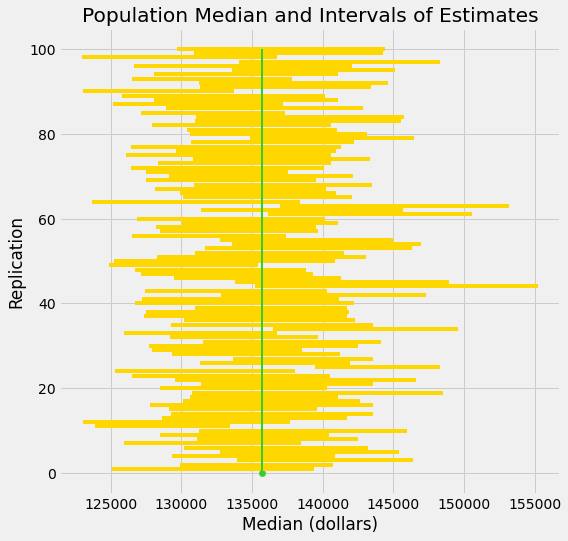

In [122]:
replication_number = np.ndarray.astype(np.arange(1, 101), str)
intervals2 = Table(replication_number).with_rows(make_array(left_ends, right_ends))

plots.figure(figsize=(8,8))
for i in np.arange(100):
    ends = intervals2.column(i)
    plots.plot(ends, make_array(i+1, i+1), color='gold')
plots.scatter(pop_median, 0, color=parameter_green, s=40, zorder=2)
plots.plot(make_array(pop_median, pop_median), make_array(0, 100), color=parameter_green, lw=2)
plots.xlabel('Median (dollars)')
plots.ylabel('Replication')
plots.title('Population Median and Intervals of Estimates');

To summarize what the simulation shows, suppose you are estimating the population median by the following process: 

- Draw a large random sample from the population.
- Bootstrap your random sample and get an estimate from the new random sample. 
- Repeat the above bootstrap step thousands of times, and get thousands of estimates.
- Pick off the "middle 95%" interval of all the estimates.

That gives you one interval of estimates. If 99 other people repeat **the entire process**, starting with a new random sample each time, then you will end up with 100 such intervals. About 95 of these 100 intervals will contain the population parameter.

In other words, this process of estimation captures the parameter about 95% of the time. 

You can replace 95% by a different value, as long as it's not 100. Suppose you replace 95% by 80% and keep the sample size fixed at 500. Then your intervals of estimates will be shorter than those we simulated here, because the "middle 80%" is a smaller range than the "middle 95%". If you keep repeating this process, only about 80% of your intervals will contain the parameter.